   Test script to load in CESM model prediction of sea ice and regrid to a polar stereo projection

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
# import glob
import seaborn as sns

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
# Data dir
data_dir = r'/home/disk/sipn/nicway/data/model/nmme/test'
# cfile = 'sic_OImon_GFDL-FLORB01_FLORB01-P1-ECDA-v3.1-062014_r9i1p1_201406-201505.nc'
cfile = 'sic_OImon_GFDL-FLORB01_FLORB01-P1-ECDA-v3.1-041980_r2i1p1_198004-198103.nc'
file_in = os.path.join(data_dir, cfile)

In [4]:
# Open Data
ds = xr.open_dataset(file_in)

In [5]:
# WHY IS THE MODEL MAX LATITUDE AT 78.78 N ?????
ds.lat.max()

<xarray.DataArray 'lat' ()>
array(78.781974)

In [6]:
# Average over all sea ice categories 
sic = ds.sic.sum(dim='ct', skipna=False)

In [7]:
# Get info about target grid
flat = r'/home/disk/sipn/nicway/data/grids/psn25lats_v3.dat'
flon = r'/home/disk/sipn/nicway/data/grids/psn25lons_v3.dat'
NY=304; 
NX=448;

def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))

In [8]:
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_out = xr.Dataset({'lat': (['x', 'y'],  lat), 'lon': (['x', 'y'], lon)})
ds_out

<xarray.Dataset>
Dimensions:  (x: 304, y: 448)
Dimensions without coordinates: x, y
Data variables:
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...

In [9]:
ds_out.max()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    lat      float64 89.84
    lon      float64 179.8

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


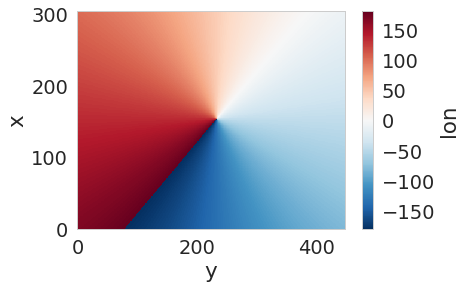

In [10]:
# Plot target lat and lon
ds_out.lon.plot.pcolormesh()

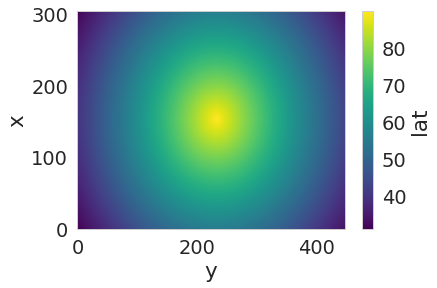

In [11]:
ds_out.lat.plot.pcolormesh()

In [24]:
sic

<xarray.DataArray 'sic' (time: 12, lat: 200, lon: 360)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-04-16 1980-05-16T12:00:00 1980-06-16 ...
  * lon      (lon) float64 -279.5 -278.6 -277.6 -276.6 -275.7 -274.7 -273.8 ...
  * lat      (lat) float64 -81.5 -80.5 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 ...

In [12]:
# Calculate regridding matrix
regridder = xe.Regridder(sic, ds_out, 'bilinear', periodic=True)
# Regrid
sic_out = regridder(sic)
# sic_out

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "


Overwrite existing file: bilinear_200x360_304x448_peri.nc 
 You can set reuse_weights=True to save computing time.


In [13]:
sic_out

<xarray.DataArray 'sic' (time: 12, x: 304, y: 448)>
array([[[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       ...,

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
    lon      (x, y) float64 168.3 168.4 168.5 168.7 168.8 168.9 169.0 169.1 ...
    lat      (x, y) float64 31.1 31.25 31.4 31.55 31.69 31.84 31.99 32.13 ...
  * time     (time) datetime64[ns] 1980-04-16 1980-05-16T12:00:00 1980-06-16 ...
Dimensions without coordinates: x, y
Attributes:
    regrid_met

In [14]:
# Define naive_fast that searches for the nearest WRF grid cell center
def naive_fast(latvar,lonvar,lat0,lon0):
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:]
    lonvals = lonvar[:]
    dist_sq = (latvals-lat0)**2 + (lonvals-lon0)**2
    minindex_flattened = dist_sq.argmin()  # 1D index of min element
    iy_min,ix_min = np.unravel_index(minindex_flattened, latvals.shape)
    return iy_min,ix_min

In [15]:
# Testing point selectoin method
# rnd_pts = list(zip(list(np.linspace(sic_out.lat.min().values,sic_out.lat.max().values,50)),
#                    list(np.linspace(sic_out.lon.min().values,sic_out.lon.max().values,50))))
# lat_err = []
# lon_err = []
# for cpt in rnd_pts:
# #     print(cpt)
#     (c_y, c_x) = naive_fast(sic_out.lat.values, sic_out.lon.values, cpt[0], cpt[1])
# #     print(sic_out.isel(x=c_x, y=c_y).lat.values, cpt[0])
# #     print(sic_out.isel(x=c_x, y=c_y).lon.values, cpt[1])
#     lat_err.append((sic_out.isel(x=c_x, y=c_y).lat-cpt[0]).values)
#     lon_err.append((sic_out.isel(x=c_x, y=c_y).lon-cpt[1]).values)
# plt.figure()
# plt.plot(np.linspace(sic_out.lat.min().values,sic_out.lat.max().values,50), lat_err)
# plt.figure()
# plt.plot(np.linspace(sic_out.lon.min().values,sic_out.lon.max().values,50), lon_err)

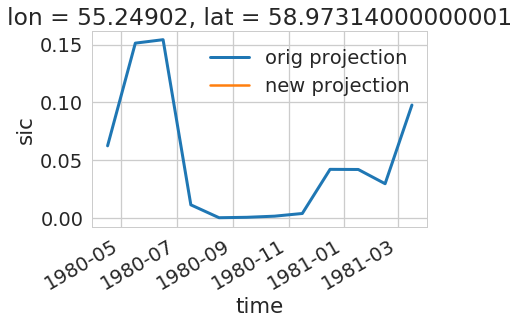

In [16]:
# Test Regridding was successful
pt_lon = 0
pt_lat = 72
(c_y, c_x) = naive_fast(sic_out.lat.values, sic_out.lon.values, pt_lat, pt_lon)
plt.figure()
sic.sel(lon=pt_lon, lat=pt_lat, method='nearest').plot(linewidth=3, label='orig projection')  # input data
sic_out.sel(x=c_x, y=c_y).plot(label='new projection')# output data
plt.legend()

In [17]:
sic

<xarray.DataArray 'sic' (time: 12, lat: 200, lon: 360)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1980-04-16 1980-05-16T12:00:00 1980-06-16 ...
  * lon      (lon) float64 -279.5 -278.6 -277.6 -276.6 -275.7 -274.7 -273.8 ...
  * lat      (lat) float64 -81.5 -80.5 -79.5 -78.5 -77.5 -76.5 -75.5 -74.5 ...

In [18]:
sic_out.lat.max()

<xarray.DataArray 'lat' ()>
array(89.83682)

In [19]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'lightgrey')

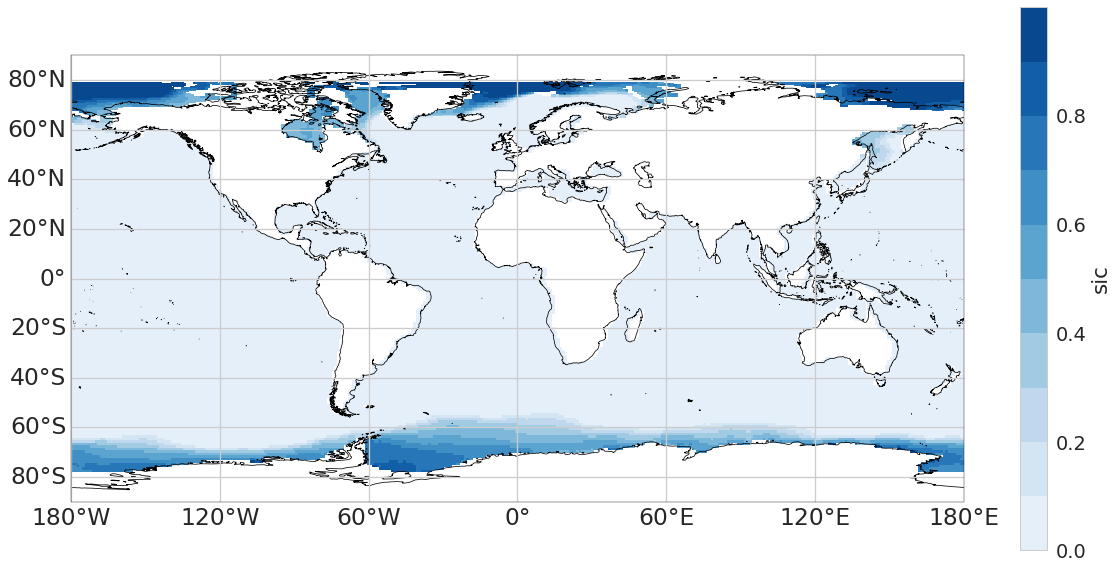

In [20]:
# Plot original projection
plt.figure(figsize=(20,10))
ax1 = plt.axes(projection=ccrs.PlateCarree())
sic.mean(dim='time').plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                 vmin=sic.min().values, vmax=sic.max().values,
                                 cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)));
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

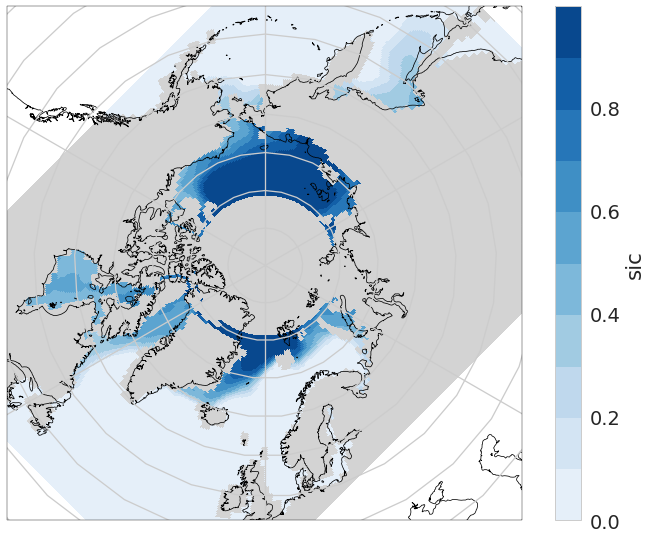

In [21]:
# Plot SIC on target projection
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
sic_out.mean(dim='time').plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='50m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
plt.tight_layout()

In [22]:
# Save new file
f_out = os.path.join(data_dir, os.path.splitext(cfile)[0]+'_Stereo.nc')
sic_out.to_netcdf(f_out)

In [23]:
# Clean up
regridder.clean_weight_file()  # clean-up

Remove file bilinear_200x360_304x448_peri.nc
